# Confusion Matrix from Predictions

Load saved predictions and create confusion matrices to see which PII labels get confused.

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.metrics import confusion_matrix
import sys

# Add parent directory to path to import utils
sys.path.insert(0, str(Path('../utils').resolve()))
from models_config import SIMPLIFIED_24_LABELS, LABEL_CONSOLIDATION_MAP

In [2]:
# === CONFIGURATION ===
PREDS_DIR = '../preds_unified'
MODEL_NAME = 'predictions_e3_jsi_domains.json'

# Load data
with open(Path(PREDS_DIR) / MODEL_NAME, 'r') as f:
    data = json.load(f)

print(f"Model: {data['model']}")
print(f"Test samples: {data['test_samples']}")

Model: E3-JSI-Domains
Test samples: 2296


In [3]:
# === PER-LABEL THRESHOLDS ===
# Adjust thresholds for each label type
# Higher threshold = stricter (fewer predictions)
# Lower threshold = more lenient (more predictions)

DEFAULT_THRESHOLD = 0.75

THRESHOLDS = {
    # Financial - high confidence needed
    'ssn': 0.75,
    'credit_card': 0.75,
    'bank_account': 0.75,
    'tax_id': 0.75,
    'iban': 0.75,
    'credit_score': 0.75,
    'amount': 0.20,  # often missed, lower threshold
    
    # Contact info
    'email': 0.75,
    'phone number': 0.75,
    'fax number': 0.75,
    'address': 0.75,
    'ip_address': 0.75,
    
    # Identity
    'full name': 0.75,
    'username': 0.75,
    'national_id': 0.20,  # often missed, lower threshold
    'health_insurance': 0.50,  # often missed, lower threshold
    
    # Medical
    'medical_condition': 0.75,
    'medication': 0.75,
    'procedure': 0.75,
    
    # Other
    'organization': 0.75,
    'date': 0.75,
}

print("Thresholds configured:")
for label, thresh in sorted(THRESHOLDS.items(), key=lambda x: x[1]):
    marker = "<-- lower" if thresh < DEFAULT_THRESHOLD else ""
    print(f"  {label:20s}: {thresh:.2f} {marker}")

Thresholds configured:
  amount              : 0.20 <-- lower
  national_id         : 0.20 <-- lower
  health_insurance    : 0.50 <-- lower
  ssn                 : 0.75 
  credit_card         : 0.75 
  bank_account        : 0.75 
  tax_id              : 0.75 
  iban                : 0.75 
  credit_score        : 0.75 
  email               : 0.75 
  phone number        : 0.75 
  fax number          : 0.75 
  address             : 0.75 
  ip_address          : 0.75 
  full name           : 0.75 
  username            : 0.75 
  medical_condition   : 0.75 
  medication          : 0.75 
  procedure           : 0.75 
  organization        : 0.75 
  date                : 0.75 


In [4]:
# === EXTRACT LABELS ===
true_labels = []
pred_labels = []

for sample in data['predictions']:
    ground_truth = sample['ground_truth']
    predictions = sample['predictions']
    
    # Filter predictions by per-label threshold
    filtered_preds = []
    for p in predictions:
        label = p['normalized_label']
        threshold = THRESHOLDS.get(label, DEFAULT_THRESHOLD)
        if p['score'] >= threshold:
            filtered_preds.append(p)
    
    # Deduplicate predictions: keep highest score for each entity text
    pred_dict = {}
    for pred in filtered_preds:
        key = pred['text'].lower().strip()
        if key not in pred_dict or pred['score'] > pred_dict[key]['score']:
            pred_dict[key] = pred
    
    # Convert to label dict
    pred_label_dict = {k: v['normalized_label'] for k, v in pred_dict.items()}
    
    # Ground truth dict (also deduplicated)
    gt_dict = {ent['entity'].lower().strip(): ent['normalized_type'] 
               for ent in ground_truth}
    
    # Compare: for each ground truth entity
    for entity_text, true_label in gt_dict.items():
        true_labels.append(true_label)
        if entity_text in pred_label_dict:
            pred_labels.append(pred_label_dict[entity_text])
        else:
            pred_labels.append('MISSED')
    
    # False positives (predicted but not in ground truth)
    for entity_text, pred_label in pred_label_dict.items():
        if entity_text not in gt_dict:
            true_labels.append('NO_ENTITY')
            pred_labels.append(pred_label)

print(f"Total comparisons: {len(true_labels)}")

Total comparisons: 8486


In [ ]:
# Choose threshold strategy
USE_PER_LABEL_THRESHOLDS = False  # Set to True to use per-label thresholds

# Global threshold (used if USE_PER_LABEL_THRESHOLDS = False)
THRESHOLD_FILTER = 0.75

# Per-label thresholds - edit DEFAULT_THRESHOLD to change all at once
DEFAULT_THRESHOLD = 0.75

LABEL_THRESHOLDS = {
    # All labels use default threshold (edit DEFAULT_THRESHOLD to change all)
    'date': DEFAULT_THRESHOLD,
    'full name': DEFAULT_THRESHOLD,
    'username': DEFAULT_THRESHOLD,
    'social security number': DEFAULT_THRESHOLD,
    'tax identification number': DEFAULT_THRESHOLD,
    'passport number': DEFAULT_THRESHOLD,
    "driver's license number": DEFAULT_THRESHOLD,
    'identification number': DEFAULT_THRESHOLD,
    'phone number': DEFAULT_THRESHOLD,
    'address': DEFAULT_THRESHOLD,
    'email address': DEFAULT_THRESHOLD,
    'ip address': DEFAULT_THRESHOLD,
    'fax number': DEFAULT_THRESHOLD,
    'credit card number': DEFAULT_THRESHOLD,
    'credit score': DEFAULT_THRESHOLD,
    'bank account number': DEFAULT_THRESHOLD,
    'amount': DEFAULT_THRESHOLD,
    'iban': DEFAULT_THRESHOLD,
    'insurance number': DEFAULT_THRESHOLD,
    'medical condition': DEFAULT_THRESHOLD,
    'medication': DEFAULT_THRESHOLD,
    'medical treatment': DEFAULT_THRESHOLD,
    'organization': DEFAULT_THRESHOLD,
}

# Using centralized label mapping from models_config (imported above)
print(f"Threshold strategy: {'Per-label' if USE_PER_LABEL_THRESHOLDS else 'Global'}")
if USE_PER_LABEL_THRESHOLDS:
    print(f"Using per-label thresholds (default: {DEFAULT_THRESHOLD})")
else:
    print(f"Using global threshold: {THRESHOLD_FILTER}")
print(f"\nUsing {len(LABEL_CONSOLIDATION_MAP)} label mappings to {len(SIMPLIFIED_24_LABELS)} simplified labels")

In [6]:
# === CONFUSION MATRIX ===
# Get all unique labels (sorted)
all_labels = sorted(set(true_labels) - {'NO_ENTITY'} | set(pred_labels) - {'MISSED'})
display_labels = all_labels + ['NO_ENTITY', 'MISSED']

cm = confusion_matrix(true_labels, pred_labels, labels=display_labels)

print(f"Matrix shape: {cm.shape}")
print(f"\nHow to read:")
print(f"  Rows = true labels")
print(f"  Columns = predicted labels")
print(f"  MISSED column = model failed to detect")
print(f"  NO_ENTITY row = false positives")

Matrix shape: (23, 23)

How to read:
  Rows = true labels
  Columns = predicted labels
  MISSED column = model failed to detect
  NO_ENTITY row = false positives


Saved: ../plots/confusion_matrix_E3_JSI_Domains.png


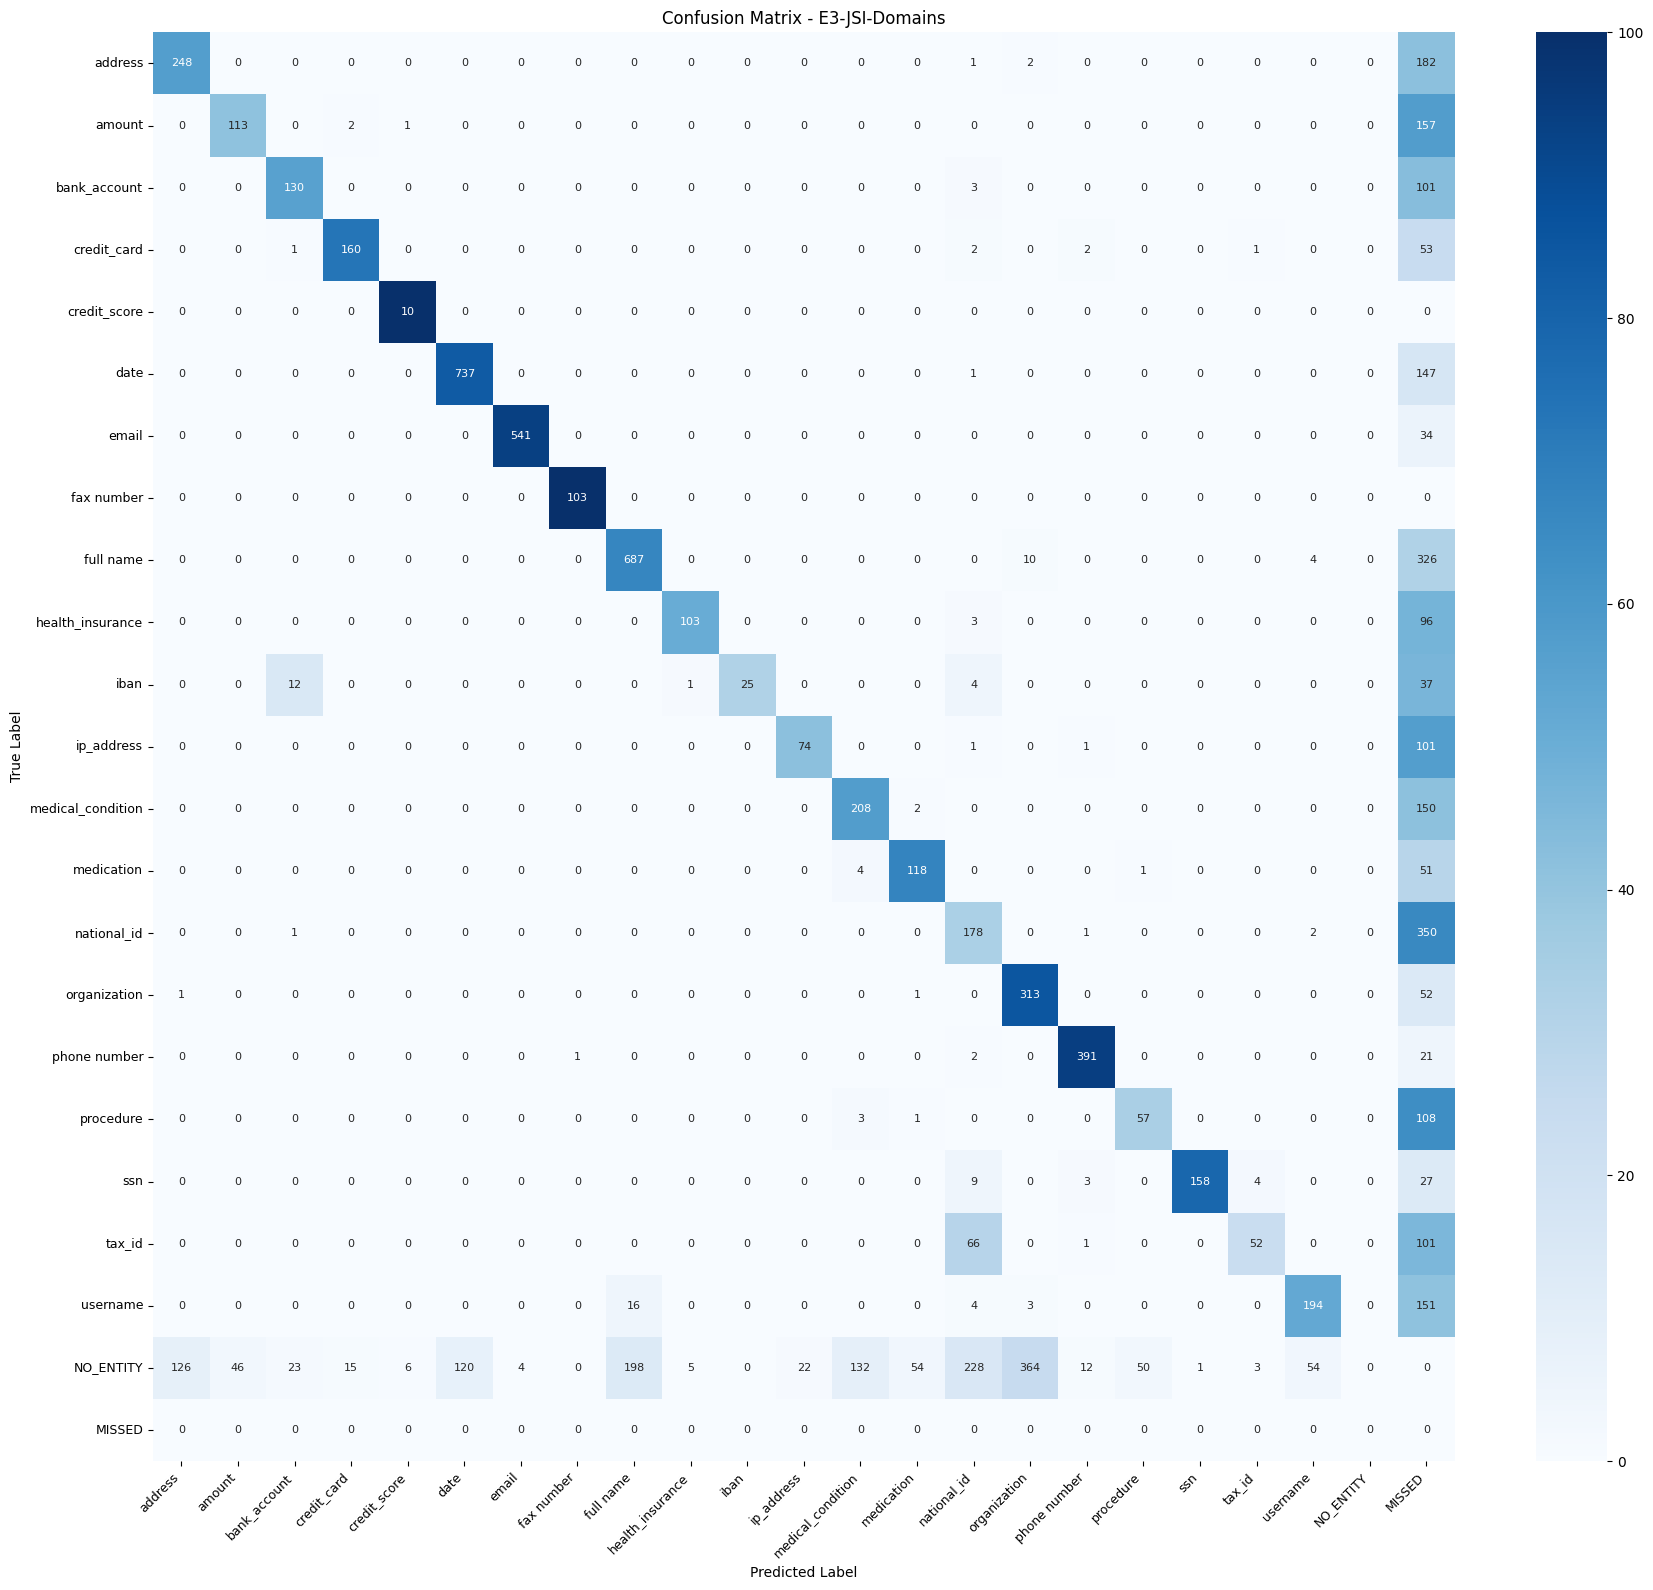

In [7]:
# === PLOT CONFUSION MATRIX ===
# Color = percentage (row-wise), Text = count
# This way credit_score with 10/10 (100%) shows dark, not light

# Create output folder
import os
PLOTS_DIR = '../plots'
os.makedirs(PLOTS_DIR, exist_ok=True)

# Normalize by row (each row sums to 1)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid division by zero
cm_percent = cm / row_sums * 100  # percentages

plt.figure(figsize=(18, 16))

# Use percentage for color, but show counts as text
sns.heatmap(cm_percent, annot=cm, fmt='d', cmap='Blues',
            xticklabels=display_labels,
            yticklabels=display_labels,
            annot_kws={'size': 8},
            vmin=0, vmax=100)  # 0-100% scale

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {data["model"]}')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

# Save
model_name = data['model'].replace(' ', '_').replace('-', '_')
plt.savefig(f'{PLOTS_DIR}/confusion_matrix_{model_name}.png', dpi=150)
print(f"Saved: {PLOTS_DIR}/confusion_matrix_{model_name}.png")

plt.show()

In [8]:
# === MOST CONFUSED PAIRS ===
confused_pairs = []

for i, true_label in enumerate(display_labels):
    for j, pred_label in enumerate(display_labels):
        if i != j and cm[i, j] > 0:
            confused_pairs.append({
                'True Label': true_label,
                'Predicted As': pred_label,
                'Count': int(cm[i, j])
            })

confused_df = pd.DataFrame(confused_pairs).sort_values('Count', ascending=False)

print("Top 15 Confused Pairs:")
print("=" * 60)
confused_df.head(15)

Top 15 Confused Pairs:


,True Label,Predicted As,Count
70,NO_ENTITY,organization,364
36,national_id,MISSED,350
18,full name,MISSED,326
69,NO_ENTITY,national_id,228
64,NO_ENTITY,full name,198
2,address,MISSED,182
5,amount,MISSED,157
56,username,MISSED,151
29,medical_condition,MISSED,150
14,date,MISSED,147


In [9]:
# === PER-LABEL ACCURACY ===
results = []

for i, label in enumerate(display_labels):
    if label in ['MISSED', 'NO_ENTITY']:
        continue
    
    total = cm[i, :].sum()
    correct = cm[i, i]
    missed = cm[i, display_labels.index('MISSED')]
    wrong = total - correct - missed
    acc = (correct / total * 100) if total > 0 else 0
    
    results.append({
        'Label': label,
        'Total': total,
        'Correct': correct,
        'Missed': missed,
        'Wrong': wrong,
        'Accuracy': f"{acc:.1f}%",
        'Threshold': THRESHOLDS.get(label, DEFAULT_THRESHOLD)
    })

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

print("Per-Label Accuracy:")
print("=" * 80)
results_df

Per-Label Accuracy:


,Label,Total,Correct,Missed,Wrong,Accuracy,Threshold
16,phone number,415,391,21,3,94.2%,0.75
6,email,575,541,34,0,94.1%,0.75
15,organization,367,313,52,2,85.3%,0.75
5,date,885,737,147,1,83.3%,0.75
18,ssn,201,158,27,16,78.6%,0.75
3,credit_card,219,160,53,6,73.1%,0.75
13,medication,174,118,51,5,67.8%,0.75
8,full name,1027,687,326,14,66.9%,0.75
12,medical_condition,360,208,150,2,57.8%,0.75
0,address,433,248,182,3,57.3%,0.75


In [ ]:
# Collect all true and predicted labels
true_labels = []
pred_labels = []

for sample in data['predictions']:
    ground_truth = sample['ground_truth']
    predictions = sample['predictions']
    
    # Filter predictions by threshold using NORMALIZED and MAPPED labels
    filtered_predictions = []
    for p in predictions:
        # Get normalized label and map it to simplified label
        normalized_label = p['normalized_label']
        # Apply label mapping to get the simplified label (for threshold lookup)
        mapped_label = LABEL_CONSOLIDATION_MAP.get(normalized_label, normalized_label)
        
        if USE_PER_LABEL_THRESHOLDS:
            # Use per-label threshold with mapped label
            threshold = LABEL_THRESHOLDS.get(mapped_label, DEFAULT_THRESHOLD)
            if p['score'] >= threshold:
                filtered_predictions.append(p)
        else:
            # Use global threshold
            if p['score'] >= THRESHOLD_FILTER:
                filtered_predictions.append(p)
    
    # Create mappings by entity text using NORMALIZED labels (already in simplified format)
    gt_dict = {ent['entity'].lower().strip(): ent['normalized_type'] 
               for ent in ground_truth}
    
    pred_dict = {pred['text'].lower().strip(): pred['normalized_label'] 
                 for pred in filtered_predictions}
    
    # For each ground truth entity
    for entity_text, true_label in gt_dict.items():
        if entity_text in pred_dict:
            # Model found this entity
            true_labels.append(true_label)
            pred_labels.append(pred_dict[entity_text])
        else:
            # Model missed this entity
            true_labels.append(true_label)
            pred_labels.append('MISSED')
    
    # For predictions not in ground truth (false positives)
    for entity_text, pred_label in pred_dict.items():
        if entity_text not in gt_dict:
            true_labels.append('NO_ENTITY')
            pred_labels.append(pred_label)

print(f"Total entity comparisons: {len(true_labels)}")
print(f"Unique true labels: {len(set(true_labels))}")
print(f"Unique predicted labels: {len(set(pred_labels))}")

if USE_PER_LABEL_THRESHOLDS:
    print(f"\nNote: Using per-label thresholds (default: {DEFAULT_THRESHOLD})")
else:
    print(f"\nNote: Predictions filtered to score >= {THRESHOLD_FILTER}")

In [11]:
# === OVERALL SUMMARY ===
total_entities = len([t for t in true_labels if t != 'NO_ENTITY'])
correct = sum(1 for t, p in zip(true_labels, pred_labels) if t == p and t != 'NO_ENTITY')
missed = sum(1 for p in pred_labels if p == 'MISSED')
false_positives = sum(1 for t in true_labels if t == 'NO_ENTITY')

print("Overall Summary")
print("=" * 40)
print(f"Total entities:    {total_entities}")
print(f"Correct:           {correct} ({correct/total_entities*100:.1f}%)")
print(f"Missed:            {missed} ({missed/total_entities*100:.1f}%)")
print(f"Wrong label:       {total_entities - correct - missed} ({(total_entities-correct-missed)/total_entities*100:.1f}%)")
print(f"False positives:   {false_positives}")

Overall Summary
Total entities:    7023
Correct:           4600 (65.5%)
Missed:            2245 (32.0%)
Wrong label:       178 (2.5%)
False positives:   1463


In [12]:
# === FALSE POSITIVE ANALYSIS ===
negative_samples = []
for sample in data['predictions']:
    if len(sample['ground_truth']) == 0:  # clean sample
        # Filter by threshold
        filtered = [p for p in sample['predictions'] 
                    if p['score'] >= THRESHOLDS.get(p['normalized_label'], DEFAULT_THRESHOLD)]
        
        # Deduplicate: keep highest score per entity
        deduped = {}
        for p in filtered:
            key = p['text'].lower().strip()
            if key not in deduped or p['score'] > deduped[key]['score']:
                deduped[key] = p
        
        negative_samples.append({'sample': sample, 'preds': list(deduped.values())})

total_neg = len(negative_samples)
correct_clean = sum(1 for s in negative_samples if len(s['preds']) == 0)

print("False Positive Analysis (Clean Samples)")
print("=" * 40)
print(f"Total clean samples:     {total_neg}")
print(f"Correctly clean:         {correct_clean} ({correct_clean/total_neg*100:.1f}%)")
print(f"With false positives:    {total_neg - correct_clean} ({(total_neg-correct_clean)/total_neg*100:.1f}%)")

False Positive Analysis (Clean Samples)
Total clean samples:     480
Correctly clean:         419 (87.3%)
With false positives:    61 (12.7%)


In [13]:
# === EXAMPLES: FALSE POSITIVES ===
fp_examples = [s for s in negative_samples if len(s['preds']) > 0]
fp_examples.sort(key=lambda x: -len(x['preds']))

print("Top 3 False Positive Examples:\n")
for i, item in enumerate(fp_examples[:3], 1):
    print(f"--- Example {i} ({len(item['preds'])} false positives) ---")
    print(f"Text: {item['sample']['text'][:150]}...\n")
    for pred in item['preds']:
        print(f"  '{pred['text']}' -> {pred['normalized_label']} ({pred['score']:.2f})")
    print()

Top 3 False Positive Examples:

--- Example 1 (3 false positives) ---
Text: Policyholder Bishakha Pillai, SSN 067-21-5289, DOB 1951-09-11, resides at 66/99 Gola Ganj....

  'Bishakha Pillai' -> full name (0.91)
  '067-21-5289' -> ssn (0.98)
  '66/99 Gola Ganj' -> address (0.95)

--- Example 2 (3 false positives) ---
Text: Given the report: "Placement of a left chest tube.  The tube could be kinked in.  No pneumothorax.  Moderate left pleural effusion with subsequent lef...

  'pneumothorax' -> medical_condition (0.77)
  'left basilar atelectasis' -> medical_condition (0.90)
  'pulmonary edema' -> medical_condition (0.80)

--- Example 3 (3 false positives) ---
Text: We're expecting the delivery of equipment at our center 484 for a clinical trial on 15/03/1929. All transport operations will be tracked via 35HCEWLV8...

  '15/03/1929' -> date (1.00)
  '35HCEWLV8NEE79995' -> national_id (0.46)
  '54-494364-826981-3' -> national_id (0.45)



In [14]:
# === EXAMPLES: MISSED ENTITIES ===
under_detection = []
for sample in data['predictions']:
    gt_count = len(sample['ground_truth'])
    pred_count = len(sample['predictions'])
    if pred_count < gt_count:
        under_detection.append({
            'sample': sample,
            'diff': gt_count - pred_count
        })

under_detection.sort(key=lambda x: -x['diff'])

print(f"Found {len(under_detection)} samples with missed entities\n")
print("Top 3 Examples:\n")
for i, item in enumerate(under_detection[:3], 1):
    sample = item['sample']
    print(f"--- Example {i} (missed {item['diff']} entities) ---")
    print(f"Text: {sample['text'][:150]}...\n")
    print(f"Ground truth:")
    for ent in sample['ground_truth']:
        print(f"  '{ent['entity']}' -> {ent['normalized_type']}")
    print()

Found 289 samples with missed entities

Top 3 Examples:

--- Example 1 (missed 8 entities) ---
Text: **Vietnam Pacific Brokerage**

**Account Statement**

**Account Holder Information**
- Customer ID: 22USR82419
- User Name: thi.nguyen
- Email: t.nguy...

Ground truth:
  'thi.nguyen' -> username
  't.nguyen@vietnampacificbrokerage.vn' -> email
  'C79234618' -> bank_account
  '$50,000.00' -> amount
  '07/15/2026' -> date
  '$5,000.00' -> amount
  '$50,000.00' -> amount
  '07/14/2026' -> date
  '$2,000.00' -> amount
  '$45,000.00' -> amount
  '07/13/2026' -> date
  '$3,000.00' -> amount
  '$47,000.00' -> amount
  '07/12/2026' -> date
  '$1,000.00' -> amount
  '$50,000.00' -> amount
  't.nguyen@vietnampacificbrokerage.vn' -> email
  '07/15/2026' -> date
  '08/15/2026' -> date

--- Example 2 (missed 7 entities) ---
Text: Hospital Course:
The patient was admitted with a provisional diagnosis of major depression with psychosis. She received electroconvulsive therapy duri...

Ground truth:
  